<a href="https://colab.research.google.com/github/AnIsAsPe/Regresion-Robusta-para-estimar-tiempo-de-respuesta-de-un-servicio-de-emergencia/blob/main/Response_time_Paris_Fire_Brigade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cargar bibiliotecas

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split 

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn import metrics

import matplotlib.pyplot as plt 
import seaborn as sns  

## Definición de funciones

In [ ]:
def correlacion(dataframe, grafica=True, matrix=False, tamaño =(12,8)):
    '''Devuelve la matriz de correlación de un dataframe
    y sí grafica=True, muestra un mapa de calor de la matriz de correlación'''
    corr=dataframe.corr()                   
    if grafica==True:
      fig = plt.figure(figsize = tamaño)
      ax = sns.heatmap(corr,
                       vmin = -1,
                       vmax = 1,
                       center = 0,
                       cmap = "coolwarm", 
                       annot = True,
                       fmt=".2f",
                       square = True)
      ax.set_xticklabels(ax.get_xticklabels(), 
                         rotation = 45,
                         horizontalalignment ='right')
    if matrix==True:
      return corr

# Cargar etiquetas

In [ ]:
# Variables respuesta
output = pd.read_csv('drive/My Drive/Datos/ParisFireBrigade/y_train.csv', 
                     index_col=[0], sep=',')
print(output.shape)
output.head(2)

(219337, 3)


,delta selection-departure,delta departure-presentation,delta selection-presentation
emergency vehicle selection,,,
5105452,86,324,410
4720915,164,297,461


In [ ]:
# Se puede verificar si la última columna es la suma de las otras dos
(output.iloc[:,0] + output.iloc[:,1] == output.iloc[:,2]).sum()==len(output)

True

Nos vamos a concentrar en el tiempo desde la salida del vehículo hasta la presentación en el lugar del siniestro

In [ ]:
Y = output['delta departure-presentation']
Y.describe()

count    219337.000000
mean        356.161026
std         228.381939
min           1.000000
25%         231.000000
50%         319.000000
75%         434.000000
max       22722.000000
Name: delta departure-presentation, dtype: float64

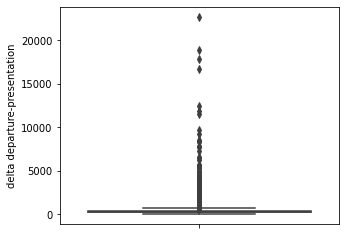

In [ ]:

plt.figure(figsize=(5,4))
sns.boxplot(y=Y, showfliers=True )

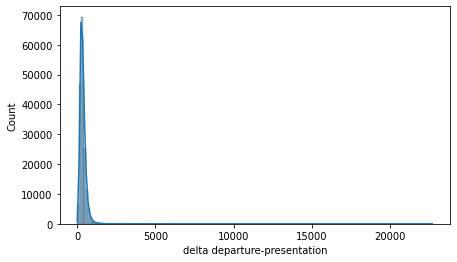

In [ ]:
#sin outliers
plt.figure(figsize=(7,4))
sns.histplot(Y, bins=200, kde=True )
plt.show()

# Cargar variables independientes

In [ ]:
# Conjunto de caracteristicas (X)
input = pd.read_csv('drive/My Drive/Datos/ParisFireBrigade/x_train.csv', 
                sep=',', index_col=[0], parse_dates=['selection time'] )
print(input.shape)
input.head(2)

(219337, 25)


,intervention,alert reason category,alert reason,intervention on public roads,floor,location of the event,longitude intervention,latitude intervention,emergency vehicle,emergency vehicle type,rescue center,selection time,date key sélection,time key sélection,status preceding selection,delta status preceding selection-selection,departed from its rescue center,longitude before departure,latitude before departure,delta position gps previous departure-departure,GPS tracks departure-presentation,GPS tracks datetime departure-presentation,OSRM response,OSRM estimated distance,OSRM estimated duration
emergency vehicle selection,,,,,,,,,,,,,,,,,,,,,,,,,
5105452,13264186,3,2162,0,0,148.0,2.284796,48.879669,4511,VSAV BSPP,2447,2018-07-08 19:02:43.990,20180708,190243,Rentré,2027,1,2.288053,48.884698,NaN,"2.289000,48.885113;2.288861,48.884998;2.288000...",2018-07-08 19:04:43;2018-07-08 19:05:55;2018-0...,"{""code"":""Ok"",""routes"":[{""geometry"":""}yjiH}x}L_...",952.5,105.8
4720915,12663715,3,2124,0,1,136.0,2.247464,48.818191,4327,PSE,2464,2018-01-04 09:02:59.470,20180104,90259,Rentré,28233,1,2.268519,48.823958,NaN,NaN,NaN,"{""code"":""Ok"",""routes"":[{""geometry"":""u|~hHy`zL_...",2238.5,243.2


In [ ]:
#Borrar columnas que no utilizaremos

col_borrar=['intervention',  #identificador de la intervención
            'emergency vehicle',  #id 749 vehículo de emergencia 
            'rescue center', # id 94 centros de rescate, estacionamiento de los vehícuos
            'alert reason', # 126 categorías, que están resumidas en 'alert reason category'
            'date key sélection', 'time key sélection', #redundantes
            'OSRM response', #rutas
            'GPS tracks departure-presentation', #rutas
            'GPS tracks datetime departure-presentation', #rutas
            'longitude intervention', 'latitude intervention', #coordenadas
            'longitude before departure',  #coordenadas
            'latitude before departure',    #coordenadas

            #variable no relaccionadas con delta departure-presentation
            'status preceding selection',  
            'delta status preceding selection-selection',
            'departed from its rescue center',
            'delta position gps previous departure-departure'
            ]
df= input.drop(columns= col_borrar)
print(df.shape)
df.head(2)

(219337, 8)


,alert reason category,intervention on public roads,floor,location of the event,emergency vehicle type,selection time,OSRM estimated distance,OSRM estimated duration
emergency vehicle selection,,,,,,,,
5105452,3,0,0,148.0,VSAV BSPP,2018-07-08 19:02:43.990,952.5,105.8
4720915,3,0,1,136.0,PSE,2018-01-04 09:02:59.470,2238.5,243.2


# Unir caracteristicas con étiquetas

In [ ]:
df=pd.concat([df,Y], axis=1)
print(df.shape)
df.head(2)

(219337, 9)


,alert reason category,intervention on public roads,floor,location of the event,emergency vehicle type,selection time,OSRM estimated distance,OSRM estimated duration,delta departure-presentation
emergency vehicle selection,,,,,,,,,
5105452,3,0,0,148.0,VSAV BSPP,2018-07-08 19:02:43.990,952.5,105.8,324
4720915,3,0,1,136.0,PSE,2018-01-04 09:02:59.470,2238.5,243.2,297


# Idetificación del tipo de variable de cada columna

Comparamos el tipo de cada columna con la documentación de los parámetros de entrada en [la documentación provista por el Challenge](https://paris-fire-brigade.github.io/data-challenge/challenge.html)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219337 entries, 5105452 to 4868867
Data columns (total 9 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   alert reason category         219337 non-null  int64         
 1   intervention on public roads  219337 non-null  int64         
 2   floor                         219337 non-null  int64         
 3   location of the event         206627 non-null  float64       
 4   emergency vehicle type        219337 non-null  object        
 5   selection time                219337 non-null  datetime64[ns]
 6   OSRM estimated distance       219337 non-null  float64       
 7   OSRM estimated duration       219337 non-null  float64       
 8   delta departure-presentation  219337 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(4), object(1)
memory usage: 16.7+ MB


In [ ]:
categoricas=['alert reason category','location of the event',
             'emergency vehicle type']
df[categoricas]=df[categoricas].astype('object')
df['intervention on public roads']=df['intervention on public roads'].astype('bool')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219337 entries, 5105452 to 4868867
Data columns (total 9 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   alert reason category         219337 non-null  object        
 1   intervention on public roads  219337 non-null  bool          
 2   floor                         219337 non-null  int64         
 3   location of the event         206627 non-null  object        
 4   emergency vehicle type        219337 non-null  object        
 5   selection time                219337 non-null  datetime64[ns]
 6   OSRM estimated distance       219337 non-null  float64       
 7   OSRM estimated duration       219337 non-null  float64       
 8   delta departure-presentation  219337 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 15.3+ MB


# Transformación de variables

###  Creación de variable Rush Hour

Variable binaria para identificar eventos en horas pico

In [ ]:
df['rush hour'] = 0

df = df.reset_index()
df = df.set_index('selection time')

#identificar el indice de los registros de eventos entresemana en hora pico
pico_am = df.index.indexer_between_time('6:30','9:30')
pico_pm = df.index.indexer_between_time('16:00','19:00')
horas_pico_index= np.concatenate((pico_am, pico_pm))
fin_de_semana_filtro = df.index.weekday > 5  #identifica sábados y domingos

df = df.reset_index()
df.iloc[list(horas_pico_index),-1] = 1 
#Regresar a 0 el valor para los días sabados y domingos
df['rush hour']= np.where(fin_de_semana_filtro, 0, df['rush hour'])

### Creación de variable Weekday
Variable binaria para identificar eventos de lunes a viernes

In [ ]:
df['weekday'] = np.where(fin_de_semana_filtro, 0, 1)

In [ ]:
#Regresar emerency vehicle selection como indice
df = df.set_index('emergency vehicle selection')

# Exploración de variables categoricas

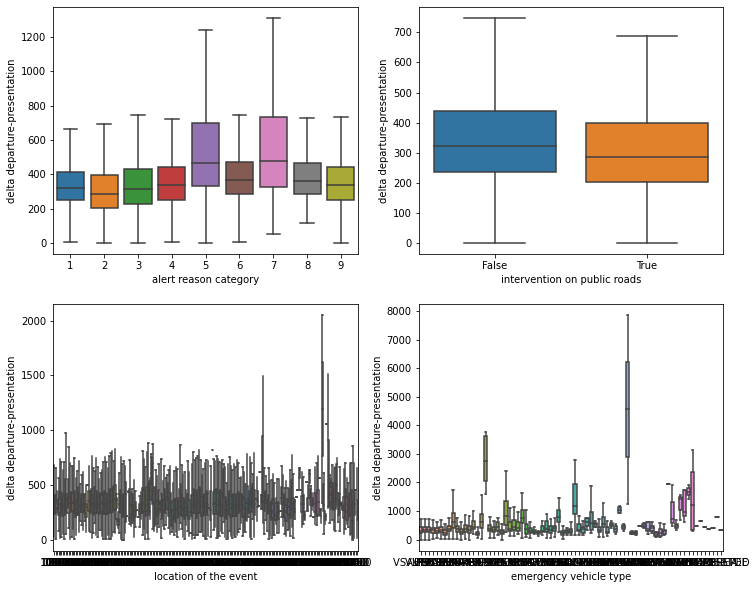

In [ ]:
cat = df.select_dtypes(include=['object', 'bool'])
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
for var, subplot in zip(cat.columns, ax.flatten()):
    sns.boxplot(x = var , y = 'delta departure-presentation', data = df,
                ax=subplot, showfliers=False )

In [ ]:
df.describe(include='object')

,alert reason category,location of the event,emergency vehicle type
count,219337,206627.0,219337
unique,9,210.0,75
top,3,139.0,VSAV BSPP
freq,176787,51031.0,159620


### Identificación de principales categorías: `location of the event`
Explorar la distribución de 'location of the event' y notar que 8 categorías concentran más de 75% de los datos

In [ ]:
df['location of the event'].value_counts(normalize=False)

139.0    51031
136.0    44400
148.0    31997
149.0     9905
140.0     5237
         ...  
247.0        1
248.0        1
284.0        1
265.0        1
324.0        1
Name: location of the event, Length: 210, dtype: int64

In [ ]:
df['location of the event'].value_counts(normalize=True).cumsum().head(8)

139.0    0.246972
136.0    0.461852
148.0    0.616705
149.0    0.664642
140.0    0.689987
107.0    0.713551
137.0    0.736196
131.0    0.751344
Name: location of the event, dtype: float64

In [ ]:
#remplazar por 'other' todos los valores no contenidos en la lista locations_fr
locations_fr= list(df['location of the event'].value_counts(normalize=True).cumsum().head(8).index)
df.loc[~df['location of the event'].isin(locations_fr),'location of the event'] = np.nan
df['location of the event'].value_counts(normalize=True, dropna=False)

NaN      0.292194
139.0    0.232660
136.0    0.202428
148.0    0.145881
149.0    0.045159
140.0    0.023877
107.0    0.022199
137.0    0.021332
131.0    0.014270
Name: location of the event, dtype: float64

### Identificación de principales categorías: `emergency vehicle type`
Explorar la distribución de 'emergency vehicle type' y notar que 3 elementos concentran más del 90% de los datos

In [ ]:
df['emergency vehicle type'].value_counts(normalize=False)

VSAV BSPP    159620
PSE           32927
VLR BSPP       5820
FPT BSPP       4107
AR             2583
              ...  
SP BALLON         1
VIRB              1
DAP               1
FPT SSLIA         1
CSP               1
Name: emergency vehicle type, Length: 75, dtype: int64

In [ ]:
df['emergency vehicle type'].value_counts(normalize=True).cumsum().head(3)

VSAV BSPP    0.727739
PSE          0.877859
VLR BSPP     0.904394
Name: emergency vehicle type, dtype: float64

In [ ]:
#remplazar por 'other' todos los valores no contenidos en la lista vehiculos_fr
vehiculos_fr= list(df['emergency vehicle type'].value_counts(normalize=True).cumsum().head(3).index)
df.loc[~df['emergency vehicle type'].isin(vehiculos_fr),'emergency vehicle type'] =np.nan
df['emergency vehicle type'].value_counts(normalize=True, dropna=False)

VSAV BSPP    0.727739
PSE          0.150121
NaN          0.095606
VLR BSPP     0.026535
Name: emergency vehicle type, dtype: float64

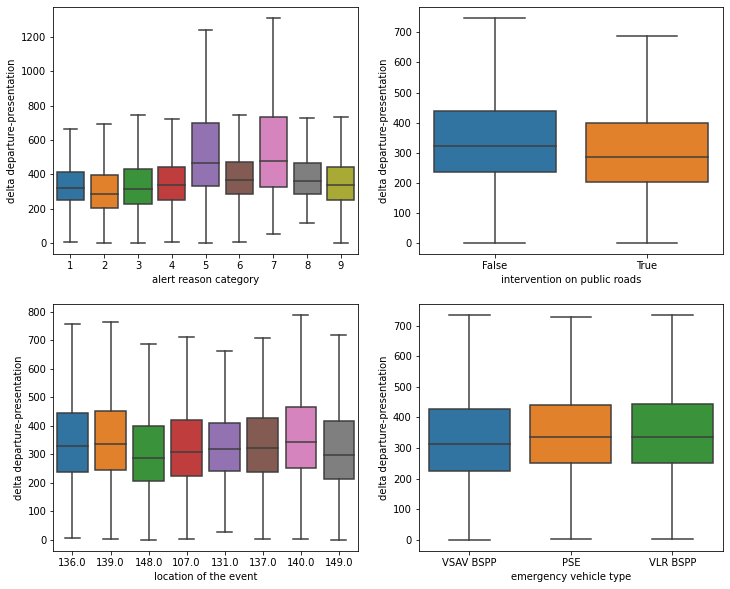

In [ ]:
cat = df.select_dtypes(include=['object', 'bool'])
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
for var, subplot in zip(cat.columns, ax.flatten()):
    sns.boxplot(x = var , y = 'delta departure-presentation', data = df,
                ax=subplot, showfliers=False )

## Hot encoding variables categoricas

In [ ]:
c1 =pd.get_dummies(df['alert reason category'],
                   drop_first=True, prefix='alert_reason catogory') 
print(c1.shape)
c1.head()

(219337, 8)


,alert_reason catogory_2,alert_reason catogory_3,alert_reason catogory_4,alert_reason catogory_5,alert_reason catogory_6,alert_reason catogory_7,alert_reason catogory_8,alert_reason catogory_9
emergency vehicle selection,,,,,,,,
5105452,0,1,0,0,0,0,0,0
4720915,0,1,0,0,0,0,0,0
5365374,0,1,0,0,0,0,0,0
4741586,0,1,0,0,0,0,0,0
5381209,0,1,0,0,0,0,0,0


In [ ]:
c2 = pd.get_dummies(df[['location of the event','emergency vehicle type']],
                   ) 
print(c2.shape)
c2.head()

(219337, 11)


,location of the event_107.0,location of the event_131.0,location of the event_136.0,location of the event_137.0,location of the event_139.0,location of the event_140.0,location of the event_148.0,location of the event_149.0,emergency vehicle type_PSE,emergency vehicle type_VLR BSPP,emergency vehicle type_VSAV BSPP
emergency vehicle selection,,,,,,,,,,,
5105452,0,0,0,0,0,0,1,0,0,0,1
4720915,0,0,1,0,0,0,0,0,1,0,0
5365374,0,0,0,0,1,0,0,0,0,0,1
4741586,0,0,1,0,0,0,0,0,0,0,1
5381209,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
df=df.drop(columns=categoricas)
df=pd.concat([df, c1, c2], axis=1)
df.shape

(219337, 27)

In [ ]:
#Llevar la etiqueta hasta la ultima posición 
cols = df.columns.tolist()
df = df[[c for c in df if c != 'delta departure-presentation'] + ['delta departure-presentation']]
print(df.shape)
df.info()

(219337, 27)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 219337 entries, 5105452 to 4868867
Data columns (total 27 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   selection time                    219337 non-null  datetime64[ns]
 1   intervention on public roads      219337 non-null  bool          
 2   floor                             219337 non-null  int64         
 3   OSRM estimated distance           219337 non-null  float64       
 4   OSRM estimated duration           219337 non-null  float64       
 5   rush hour                         219337 non-null  int64         
 6   weekday                           219337 non-null  int64         
 7   alert_reason catogory_2           219337 non-null  uint8         
 8   alert_reason catogory_3           219337 non-null  uint8         
 9   alert_reason catogory_4           219337 non-null  uint8         
 10  alert_reason

# Exploración de las variables numéricas

In [ ]:
boleanas=[]
for col in df.columns:
  if df[col].nunique()==2:
    boleanas.append(col)
df[boleanas]=df[boleanas].astype('bool')

In [ ]:
df[boleanas].describe()

,intervention on public roads,rush hour,weekday,alert_reason catogory_2,alert_reason catogory_3,alert_reason catogory_4,alert_reason catogory_5,alert_reason catogory_6,alert_reason catogory_7,alert_reason catogory_8,alert_reason catogory_9,location of the event_107.0,location of the event_131.0,location of the event_136.0,location of the event_137.0,location of the event_139.0,location of the event_140.0,location of the event_148.0,location of the event_149.0,emergency vehicle type_PSE,emergency vehicle type_VLR BSPP,emergency vehicle type_VSAV BSPP
count,219337,219337,219337,219337,219337,219337,219337,219337,219337,219337,219337,219337,219337,219337,219337,219337,219337,219337,219337,219337,219337,219337
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
freq,187201,171426,189459,213632,176787,218116,218556,214523,218436,218960,211856,214468,216207,174937,214658,168306,214100,187340,209432,186410,213517,159620


In [ ]:
numericas = list(df.select_dtypes(include=['int64', 'float64']).columns)
numericas

['floor',
 'OSRM estimated distance',
 'OSRM estimated duration',
 'delta departure-presentation']

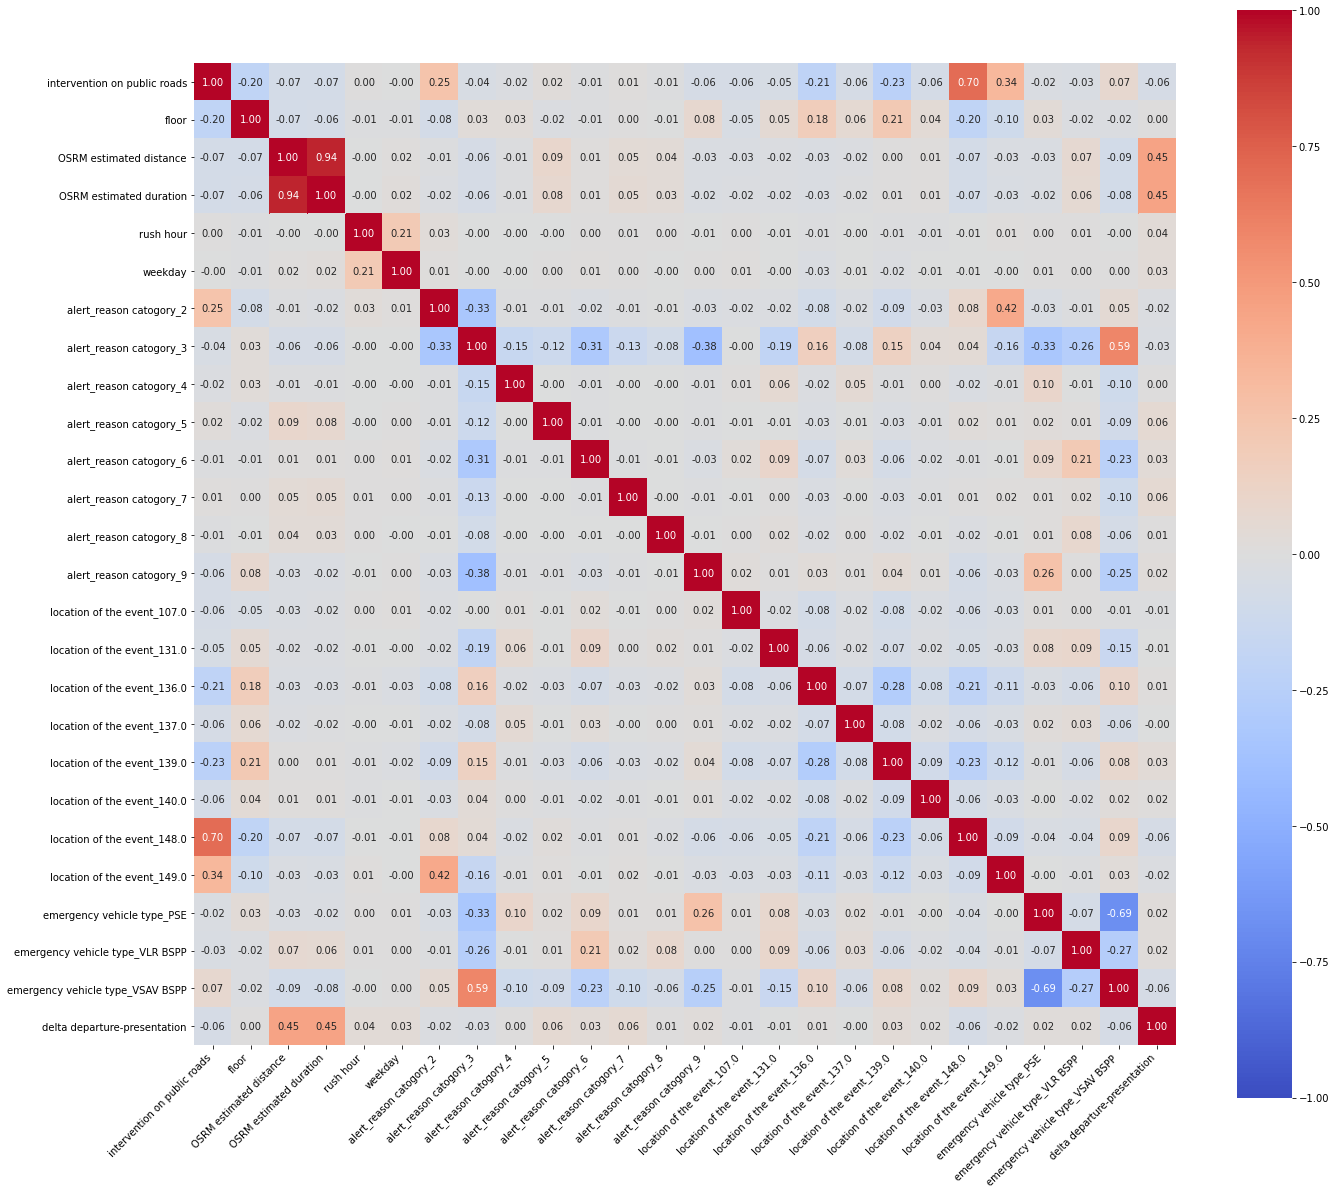

In [ ]:
corr_matrix = correlacion(df, matrix = True, tamaño=(22,20))

## Borrar redundantes

In [ ]:
#Identificar variables redundantes 

# Triangulo superior de la matriz de correlación en números absolutos
triangulo_sup = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape),
                                                1).astype(np.bool))

# Encontrar las columnas donde la correlación es 1
borrar = [column for column in triangulo_sup.columns
          if any(triangulo_sup[column] >= .7)]
borrar

['OSRM estimated duration']

In [ ]:
df = df.drop('OSRM estimated duration', axis=1)

#cols = df.columns.tolist()
#df = df[[c for c in df if c != 'delta selection-presentation'] + ['delta selection-presentation']]

numericas = list(df.select_dtypes(include=['int64', 'float64']).columns)

In [ ]:
df[numericas].describe()


,floor,OSRM estimated distance,delta departure-presentation
count,219337.000000,219337.000000,219337.000000
mean,1.201772,2238.134131,356.161026
std,2.500414,1591.647524,228.381939
min,-10.000000,0.800000,1.000000
25%,0.000000,1221.100000,231.000000
50%,0.000000,1866.800000,319.000000
75%,2.000000,2834.600000,434.000000
max,100.000000,42752.800000,22722.000000


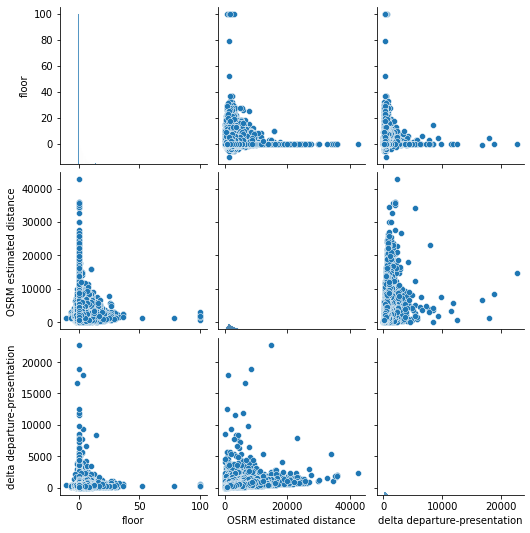

In [ ]:
sns.pairplot(df[numericas])

# Exploración de Outliers

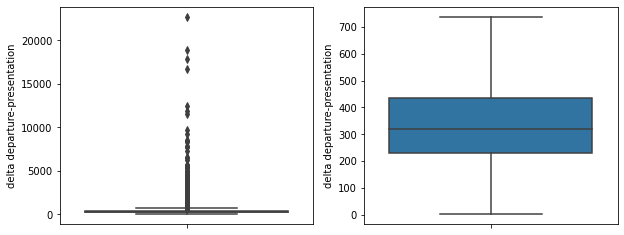

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for cond, subplot in zip((True, False), ax.flatten()):
  sns.boxplot(y=df['delta departure-presentation'], showfliers=cond, ax= subplot)

## Identificar "a ojo" *outliers*

In [ ]:
df['delta departure-presentation'].describe()

count    219337.000000
mean        356.161026
std         228.381939
min           1.000000
25%         231.000000
50%         319.000000
75%         434.000000
max       22722.000000
Name: delta departure-presentation, dtype: float64

In [ ]:
df['delta departure-presentation'].quantile(.975)

806.0

In [ ]:
df['outlier'] = 0
filtro_out = df['delta departure-presentation'] > df['delta departure-presentation'].quantile(.975)
df.loc[filtro_out,'outlier'] = 1

In [ ]:
df['outlier'].value_counts()

0    213857
1      5480
Name: outlier, dtype: int64

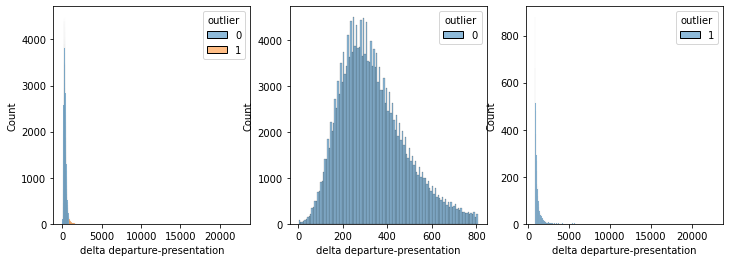

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for dat, subplot in zip((df, df[-filtro_out], df[filtro_out]), ax.flatten()):
  sns.histplot(x='delta departure-presentation', hue='outlier', 
               data=dat, ax=subplot )
plt.show()

In [ ]:
seleccion = ((df['OSRM estimated distance']>20350) & (df['OSRM estimated distance']<20500))
df[seleccion].head()

,selection time,intervention on public roads,floor,OSRM estimated distance,rush hour,weekday,alert_reason catogory_2,alert_reason catogory_3,alert_reason catogory_4,alert_reason catogory_5,alert_reason catogory_6,alert_reason catogory_7,alert_reason catogory_8,alert_reason catogory_9,location of the event_107.0,location of the event_131.0,location of the event_136.0,location of the event_137.0,location of the event_139.0,location of the event_140.0,location of the event_148.0,location of the event_149.0,emergency vehicle type_PSE,emergency vehicle type_VLR BSPP,emergency vehicle type_VSAV BSPP,delta departure-presentation,outlier
emergency vehicle selection,,,,,,,,,,,,,,,,,,,,,,,,,,,
4808363,2018-02-15 10:58:51.493,False,0,20451.1,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1171,1
5320305,2018-10-25 16:32:40.670,False,0,20373.2,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,609,0
4832811,2018-02-28 17:44:03.653,False,0,20420.9,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,1571,1


# Comparación Regresión lineal, Regresión robusta

In [ ]:
Z = df['delta departure-presentation']
X = df.drop(['selection time', 'delta departure-presentation', 'outlier'],
            axis=1)

X_train, X_test, Z_train, Z_test = train_test_split(X, Z, 
                                                    test_size=0.3, 
                                                    shuffle=True,
                                                    random_state=261)

# Guardamos datos preprocesados

In [ ]:
df_preprocesado = pd.concat([X,Z], axis=1)
#comprobamos dimensiones
X.shape,    Z.shape,   df_preprocesado.shape

((219337, 24), (219337,), (219337, 25))

In [ ]:
df_preprocesado.to_csv('/content/drive/MyDrive/Datos/ParisFireBrigade/Output/df_selec.csv')

In [ ]:
# ¿Cómo son los conjuntos de entrenamiento y prueba?
print("Conjunto de entrenamiento")
print("X: ", X_train.shape)
print("y: ", Z_train.shape)

print("Conjunto de prueba")
print("X: ", X_test.shape)
print("y: ", Z_test.shape)

Conjunto de entrenamiento
X:  (153535, 24)
y:  (153535,)
Conjunto de prueba
X:  (65802, 24)
y:  (65802,)


## Regresión Lineal

In [ ]:
lr = LinearRegression().fit(X_train, Z_train)

Z_pred = lr.predict(X_test)

error_medio_absoluto = np.mean(np.absolute(Z_test - Z_pred ))
error_medio_absoluto

107.83601593188443

In [ ]:
metrics.mean_absolute_error(Z_test, Z_pred)

107.83601593188536

In [ ]:
lr.coef_

array([-7.93424190e+00,  1.07167745e+00,  6.50667014e-02,  2.02638214e+01,
        1.36081842e+01,  8.13376443e-01,  1.94814257e+01,  3.57161604e+01,
        8.70322944e+01,  7.13925026e+01,  1.84455930e+02, -1.96557210e+01,
        4.33227201e+01,  1.42352025e+01,  1.62490483e+01,  2.78112709e+01,
        2.07493091e+01,  2.80834146e+01,  2.90893683e+01,  1.00744336e+01,
        2.44529806e+01,  1.85589167e+01, -8.92188312e-01,  8.76930670e-01])

In [ ]:
#calculamos los errores
errores = (np.array(Z_test) - Z_pred)
len(errores)

65802

In [ ]:
#una de las hipotesis de la regresión es que los errores son
#independientes  entre sí, teniendo una distribución normal

media = np.mean(Z_test - Z_pred)           
des_est = np.sqrt(np.var(Z_test - Z_pred))

media,des_est

(1.5948657003933484, 203.20675456100642)

### Comparación de los errores empirícos con una la distribución normal

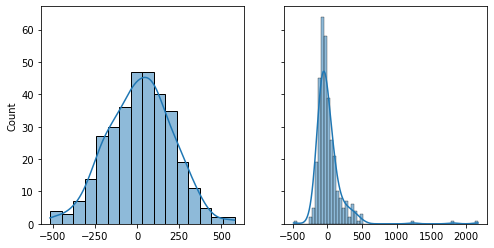

In [ ]:
# Comparación de la distribución teórica(normal) y empirica de los errores

# Se elige una submuestra (%0.5) con el propósito de obtener una mejor visualización
errores_empiricos = np.random.choice(errores, 329)

# Se obtienen 329 valores a partir de la distribución normal (teorica) usando la media
# y la desviación de los errores
errores_teoricos = np.random.normal(media, des_est, 329)

# Comparamos las gráficas de ambas distribuciones

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey='all')
for dat, subplot in zip((errores_teoricos, errores_empiricos), ax.flatten()):
  sns.histplot(x=dat, ax=subplot, kde=True, )
  
plt.show()

### Calculo de [$R^2$](https://docs.google.com/presentation/d/1k0aYwEBzaaAkWjX6jRKAc40nKHi3FROkJwtXCOE22mI/edit#slide=id.ga8926b2cd2_0_14) 

$MSE = \cfrac{1}{n}\sum{( y - y_{pred})}^2$

 $R^2 	= 1 -  \cfrac{MSE(modelo)}{MSE(linea~base)}$


In [ ]:
# Error cuadrado medio (MSE) linea base (promedio de las etiquetas)

errores_lb = Z_test - Z_test.mean()
MSE_base = pow(errores_lb,2).sum()/len(errores_lb)
MSE_base

52114.94299180111

In [ ]:
#Error cuadrado medio (MSE) modelo
errores = Z_test - Z_pred

MSE_modelo = pow(errores,2).sum()/len(errores)
MSE_modelo

41295.528695819026

In [ ]:
R2 = 1 - MSE_modelo/MSE_base #¿cuánto mejora la predicción nuestro modelo?
R2

0.20760675681222995

In [ ]:
R2 = 1 - MSE_base/MSE_base
R2

0.0

In [ ]:
def R_cuadrada(val_obs, val_pred):
  errores_lb = val_obs - val_obs.mean()
  errores_m = val_obs - val_pred
  MSE_base = pow(errores_lb,2).sum()/len(errores_lb)
  MSE_modelo = pow(errores,2).sum()/len(errores)
  R2 = 1 - MSE_modelo/MSE_base
  return R2

In [ ]:
R_cuadrada(Z_test, Z_pred)

0.20760675681222995

In [ ]:
metrics.r2_score(Z_test, Z_pred)

0.20760675681223006

## Regresión Robusta

In [ ]:
hr = HuberRegressor( epsilon=1.35,   max_iter=1000,  alpha=0,  warm_start=False, 
                    fit_intercept=True, tol=1e-05)
hr = hr.fit(X_train, Z_train)
Z_pred = hr.predict(X_test)

print(metrics.mean_absolute_error(Z_test, Z_pred))
print('MAE:', metrics.mean_absolute_error(Z_test, Z_pred))

104.59768631813472
MAE: 104.59768631813472


In [ ]:
hr.coef_

array([-3.23701457,  0.99278182,  0.07201599, 10.99230166, 13.50434019,
        1.6194606 ,  3.05169243,  5.17935761,  4.17668701, 31.09483393,
        8.40857003,  0.60675088, 20.67460989,  8.13682196, 10.61327219,
       23.9598798 , 11.48622774, 23.82693293, 10.13174744, -2.04931164,
        7.9026072 , 41.60304362, 13.75242416, 15.51899131])

In [ ]:
coeficientes_hr = pd.DataFrame({'coef':hr.coef_, 'variable':list(X.columns)})
coeficientes_hr.sort_values('coef').reset_index(drop=True)

,coef,variable
0,-3.237015,intervention on public roads
1,-2.049312,location of the event_148.0
2,0.072016,OSRM estimated distance
3,0.606751,alert_reason catogory_8
4,0.992782,floor
5,1.619461,alert_reason catogory_2
6,3.051692,alert_reason catogory_3
7,4.176687,alert_reason catogory_5
8,5.179358,alert_reason catogory_4
9,7.902607,location of the event_149.0


# Regresiones con datos normalizados

In [ ]:
X_estandarizados=X.copy()
columnas = X.columns

scaler = StandardScaler()

X_estandarizados[columnas] = scaler.fit_transform(X[columnas])

In [ ]:

X_train, X_test, Z_train, Z_test = train_test_split(X_estandarizados, Z, test_size=0.3, 
                                                    shuffle=True, random_state=261)

In [ ]:
hr = HuberRegressor( epsilon=1.35,   max_iter=1000,  alpha=0,  warm_start=False, 
                    fit_intercept=True, tol=1e-05)
hr = hr.fit(X_train, Z_train)
Z_pred = hr.predict(X_test)

print(metrics.mean_absolute_error(Z_test, Z_pred))

104.22840875649167


In [ ]:
coeficientes_hr = pd.DataFrame({'coef':hr.coef_, 'variable':list(columnas)})
coeficientes_hr.sort_values('coef').reset_index(drop=True)

,coef,variable
0,-2.565466,alert_reason catogory_2
1,-1.898818,intervention on public roads
2,-1.152103,alert_reason catogory_3
3,-0.516251,emergency vehicle type_VLR BSPP
4,-0.010105,alert_reason catogory_8
5,1.411252,alert_reason catogory_4
6,1.686061,location of the event_131.0
7,2.129649,location of the event_148.0
8,2.228416,location of the event_107.0
9,2.622261,alert_reason catogory_9
